In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
cudnn.benchmark = True
plt.ion()   # interactive mode
from utils.ImagesDataset import ImagesDataset
from tqdm import tqdm
CLASSES=14

# Dataset

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomRotation(20),
        transforms.RandomAdjustSharpness(1.5),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]),
}
train_set = ImagesDataset(data_transforms['train'],noval=False)
val_set = ImagesDataset(data_transforms['val'],train=False)
val_set.__len__()

66829

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu")

### dataloader

In [4]:
bs=128
dataset_sizes = {'train':train_set.__len__(),'val': val_set.__len__()}
train_loader = DataLoader(dataset=train_set,
                          batch_size=bs,
                          shuffle=True,
                          num_workers=4)
val_loader = DataLoader(dataset=val_set,
                          batch_size=bs,
                          shuffle=True,
                          num_workers=4)
dataloaders={'train':train_loader,'val':val_loader}

# Training

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    hist=[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
   
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                batches=0
                for inputs, labels in tepoch:
                    tepoch.set_description(f"Epoch {epoch}")
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        #print('out',outputs)
                        #print('labels',labels)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    batches+=1                      
                    tepoch.set_postfix(loss=running_loss/(batches*bs), accuracy=100. * running_corrects.item()/(batches*bs))
                    hist.append([running_loss/(batches*bs),100. * running_corrects.item()/(batches*bs)])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,hist

### setup

In [10]:
model_ft = models.efficientnet_b0(pretrained=True)

model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/ecbm4040/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [11]:
model_ft,hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------


Epoch 0: 100%|███████████████████████████████████| 1159/1159 [12:52<00:00,  1.50batch/s, accuracy=75.4, loss=0.793]


train Loss: 0.7941 Acc: 0.7547


Epoch 0: 100%|█████████████████████████████████████| 523/523 [02:16<00:00,  3.82batch/s, accuracy=76.8, loss=0.683]


val Loss: 0.6840 Acc: 0.7697

Epoch 1/3
----------


Epoch 1: 100%|████████████████████████████████████| 1159/1159 [12:47<00:00,  1.51batch/s, accuracy=85.7, loss=0.42]


train Loss: 0.4208 Acc: 0.8582


Epoch 1: 100%|█████████████████████████████████████| 523/523 [02:14<00:00,  3.88batch/s, accuracy=78.7, loss=0.668]


val Loss: 0.6690 Acc: 0.7887

Epoch 2/3
----------


Epoch 2: 100%|███████████████████████████████████| 1159/1159 [12:46<00:00,  1.51batch/s, accuracy=88.1, loss=0.349]


train Loss: 0.3491 Acc: 0.8820


Epoch 2: 100%|█████████████████████████████████████| 523/523 [02:14<00:00,  3.89batch/s, accuracy=78.5, loss=0.672]


val Loss: 0.6728 Acc: 0.7868

Epoch 3/3
----------


Epoch 3: 100%|███████████████████████████████████| 1159/1159 [12:50<00:00,  1.50batch/s, accuracy=88.5, loss=0.338]


train Loss: 0.3384 Acc: 0.8862


Epoch 3: 100%|█████████████████████████████████████| 523/523 [02:14<00:00,  3.89batch/s, accuracy=78.6, loss=0.672]

val Loss: 0.6734 Acc: 0.7871

Training complete in 60m 18s
Best val Acc: 0.788744


In [12]:
torch.save(model_ft.state_dict(), './models/efficientnet_b0.pt')
import pickle
with open('./models/efficientnet_b0_hist.pkl', 'wb') as f:
    pickle.dump(hist, f)

Text(0.5, 1.0, 'Training metrics')

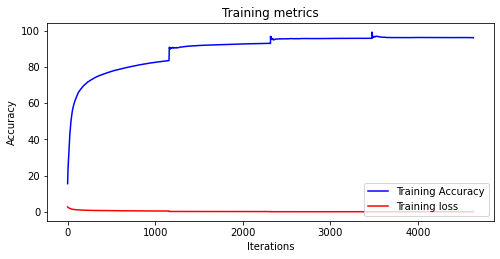

In [16]:

with open('./models/resnet18_hist.pkl', 'rb') as f:
    resnet18_hist = pickle.load(f)
resnet18_hist

losses=[i[0] for i in resnet18_hist]
accs=[i[1] for i in resnet18_hist]
#my bad mixed training and val metrics
522
train_accs=accs[0:1159]+accs[1159+523:1159*2+523]+accs[1159*2+523*2:1159*3+523*2]+accs[1159*3+523*3:1159*4+523*3]
train_loss=losses[0:1159]+losses[1159+523:1159*2+523]+losses[1159*2+523*2:1159*3+523*2]+losses[1159*3+523*3:1159*4+523*3]

val_accs=accs[1159:1159+523]+accs[1159*2+523:1159*2+523*2]+accs[1159*3+523*2:1159*3+523*3]+accs[1159*4+523*3:1159*4+523*4]
val_loss=losses[1159:1159+523]+losses[1159*2+523:1159*2+523*2]+losses[1159*3+523*2:1159*3+523*3]+losses[1159*4+523*3:1159*4+523*4]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accs, label='Training Accuracy', color="blue")
plt.plot(train_loss, label='Training loss', color="r")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Training metrics')

Text(0.5, 1.0, 'Validation metrics')

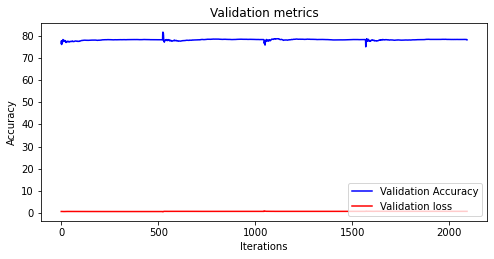

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(val_accs, label='Validation Accuracy', color="blue")
plt.plot(val_loss, label='Validation loss', color="r")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Validation metrics')

# Evaluation

In [6]:
model_ft = models.efficientnet_b0(pretrained=True)

model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=CLASSES)
model_ft = model_ft.to(device)


#reloading saved weights
model_ft.load_state_dict(torch.load('./models/efficientnet_b0.pt'))
model_ft.eval()



All_preds=[]
All_probs=[]
All_labels=[]
#evaluation

import time

start = time.time()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    with tqdm(dataloaders['val'], unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description('progress')
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_ft(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            
            prob = torch.nn.functional.softmax(outputs, dim=1)

            top_p, top_class = prob.topk(1, dim = 1)
            top_p=torch.reshape(top_p, (-1,))
           
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            All_preds+=predicted.tolist()
            All_labels+=labels.tolist()
            All_probs+=top_p.tolist()
        acc = 100.0 * n_correct / n_samples
        print(f'Validation accuracy : {acc} %')
end = time.time()
print('Total inference time: ', end - start,'sec')

progress: 100%|███████████████████████████████████████████████████████████████| 523/523 [02:10<00:00,  4.01batch/s]

Validation accuracy : 78.87444073680588 %
Total inference time:  130.52370023727417 sec


In [8]:
#inference time
print('inference time per sample for batch size 128:',(end - start)*1000/val_set.__len__(),'ms')


# F1 SCORES
from sklearn.metrics import f1_score, roc_curve, auc,plot_roc_curve,RocCurveDisplay,roc_curve
print('micro f1 score:',f1_score(All_labels, All_preds, average='micro'))
print('macro f1 score:',f1_score(All_labels, All_preds, average='macro'))

inference time per sample for batch size 128: 1.953099705775549 ms
micro f1 score: 0.7887444073680587
macro f1 score: 0.48675598023556804
